# HW 4 - Arthi Seetharaman

# Task 2

Dataset Selection

Link to Dataset: https://www.kaggle.com/datasets/tarunpaparaju/apple-aapl-historical-stock-data

This dataset includes daily statistics about Apple's Stock (AAPL) from 2010 - 2020. With this dataset, a problem that can be solved is predicted future APPL prices, which can help people decide if when/how much to invest in the stocks. Sequence models are suitable for stock price prediction because they can capture patterns that are unique to time series datasets, which then helps make a more accurate prediction. 

The framework I am using is Tensorflow.

In [121]:
#Importing neccesary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.metrics import MeanSquaredError

# EDA and Data Preprocessing

In [122]:
#Loading the dataset
path = 'stock.csv'
data = pd.read_csv(path)

In [124]:
#First few rows of dataset
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,2/28/20,$273.36,106721200,$257.26,$278.41,$256.37
1,2/27/20,$273.52,80151380,$281.10,$286,$272.96
2,2/26/20,$292.65,49678430,$286.53,$297.88,$286.50
3,2/25/20,$288.08,57668360,$300.95,$302.53,$286.13
4,2/24/20,$298.18,55548830,$297.26,$304.18,$289.23


In [125]:
#Checking for missing values
data.isnull().sum()

Date           0
 Close/Last    0
 Volume        0
 Open          0
 High          0
 Low           0
dtype: int64

In [126]:
#Replace $
data[' Close/Last'] = data[' Close/Last'].replace('[\$,]', '', regex=True).astype(float)
data[' Open'] = data[' Open'].replace('[\$,]', '', regex=True).astype(float)
data[' High'] = data[' High'].replace('[\$,]', '', regex=True).astype(float)
data[' Low'] = data[' Low'].replace('[\$,]', '', regex=True).astype(float)

In [127]:
data.describe()

,Close/Last,Volume,Open,High,Low
count,2518.000000,2.518000e+03,2518.000000,2518.000000,2518.000000
mean,114.769627,7.258009e+07,114.728558,115.766541,113.690659
std,60.662349,5.663113e+07,60.546889,61.134394,60.085100
min,29.840000,1.136205e+07,29.390000,29.930000,28.460000
25%,66.825000,3.053026e+07,66.877500,67.472500,66.375000
50%,101.090000,5.295469e+07,101.115000,102.085000,100.350000
75%,154.630000,9.861006e+07,154.610000,155.735000,153.325000
max,327.200000,4.624423e+08,324.740000,327.850000,323.350000


In [128]:
#Converting to proper format
data['Date'] = pd.to_datetime(data['Date'])

#Sorting by date
data = data.sort_values('Date')
data.reset_index(drop=True, inplace=True)

data.head()

,Date,Close/Last,Volume,Open,High,Low
0,2010-03-01,29.86,137312041,29.39,29.93,29.35
1,2010-03-02,29.84,141486282,29.99,30.12,29.68
2,2010-03-03,29.90,92846488,29.85,29.98,29.71
3,2010-03-04,30.10,89591907,29.90,30.13,29.80
4,2010-03-05,31.28,224647427,30.71,31.39,30.66


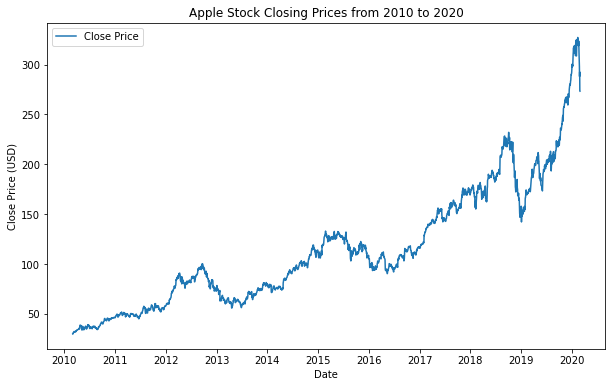

In [129]:
#Plotting the closing prices
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data[' Close/Last'], label='Close Price')
plt.title('Apple Stock Closing Prices from 2010 to 2020')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

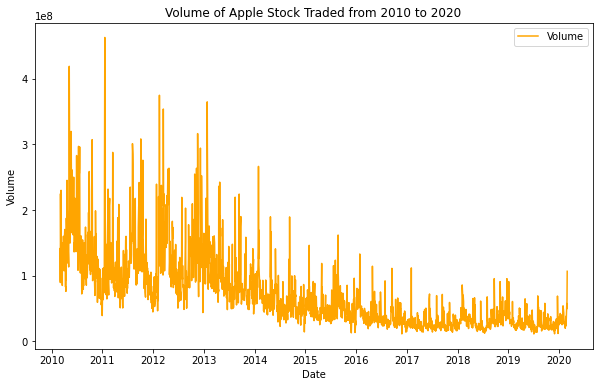

In [130]:
#Plotting Volume
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data[' Volume'], label='Volume', color='orange')
plt.title('Volume of Apple Stock Traded from 2010 to 2020')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

              Close/Last    Volume      Open      High       Low
 Close/Last     1.000000 -0.608502  0.999653  0.999828  0.999842
 Volume        -0.608502  1.000000 -0.607704 -0.605073 -0.611776
 Open           0.999653 -0.607704  1.000000  0.999842  0.999810
 High           0.999828 -0.605073  0.999842  1.000000  0.999756
 Low            0.999842 -0.611776  0.999810  0.999756  1.000000


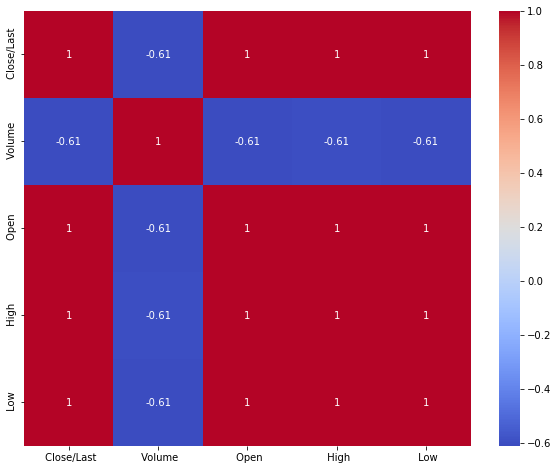

In [131]:
#Display the correlation matrix
correlation_matrix = data.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [132]:
dataset = data[' Close/Last'].values.reshape(-1, 1)

#Data preprocessing
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(dataset)

# Part 1 - Simple RNN Implementation

In [133]:
#Function to create sequences for the RNN's
def dataset_3d_split(data, length):
    
    X, y = [], []
    
    for i in range(len(data) - length):
        X.append(data[i:i + length])
        y.append(data[i + length])
        
    return np.array(X), np.array(y)

In [134]:
#Number of days to use for prediction
length = 30
X, y = dataset_3d_split(data_normalized, length)

# Splitting the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)


# Reshaping the data to fit the model input requirements
# This step is necessary because RNN models in TensorFlow expect data to be in a 3D shape (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape)

(1741, 1, 30)


In [135]:
model_rnn = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(1, length)),
    Dense(1, activation='linear')
])

model_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError()])

rnn_losses = model_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
55/55 [==============================] - 2s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 2.4471e-04 - mean_squared_error: 2.4471e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 1.9118e-04 - mean_squared_error: 1.9118e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 1.5308e-04 - mean_squared_error: 1.5308e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 1.2318e-04 - mean_squared_error: 1.2318e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 1.1674e-04 - mean_squared_error: 1.1674e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020


Epoch 48/50
55/55 [==============================] - 0s 2ms/step - loss: 3.8804e-05 - mean_squared_error: 3.8804e-05 - val_loss: 1.4758e-04 - val_mean_squared_error: 1.4758e-04
Epoch 49/50
55/55 [==============================] - 0s 2ms/step - loss: 3.4547e-05 - mean_squared_error: 3.4547e-05 - val_loss: 1.8352e-04 - val_mean_squared_error: 1.8352e-04
Epoch 50/50
55/55 [==============================] - 0s 2ms/step - loss: 5.8578e-05 - mean_squared_error: 5.8578e-05 - val_loss: 2.2578e-04 - val_mean_squared_error: 2.2578e-04


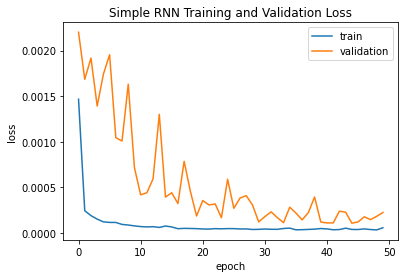

In [136]:
plt.plot(rnn_losses.history['loss'], label='train')
plt.plot(rnn_losses.history['val_loss'], label='validation')
plt.title('Simple RNN Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Part 2 - LSTM and GRU

LSTM

In [137]:
model_lstm = Sequential([
    LSTM(50, activation='tanh', input_shape=(1, length)),
    Dense(1, activation='linear')
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError()])

lstm_losses = model_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
55/55 [==============================] - 0s 3ms/step - loss: 5.4956e-05 - mean_squared_error: 5.4956e-05 - val_loss: 1.0897e-04 - val_mean_squared_error: 1.0897e-04
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 3.8339e-05 - mean_squared_error: 3.8339e-05 - val_loss: 1.1161e-04 - val_mean_squared_error: 1.1161e-04
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 6.6852e-05 - mean_squared_error: 6.6852e-05 - val_loss: 1.6087e-04 - val_mean_squared_error: 1.6087e-04
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 6.8517e-05 - mean_squared_error: 6.8517e-05 - val_loss: 1.1837e-04 - val_mean_squared_error: 1.1837e-04
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 3.2350e-05 - mean_squared_error: 3.2350e-05 - val_loss: 2.5534e-04 - val_mean_squared_error: 2.5534e-04
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 3.8099e-05 - mean_squared_error: 3.8099e-05 - va

55/55 [==============================] - 0s 2ms/step - loss: 6.2450e-05 - mean_squared_error: 6.2450e-05 - val_loss: 9.7426e-05 - val_mean_squared_error: 9.7426e-05
Epoch 48/50
55/55 [==============================] - 0s 2ms/step - loss: 4.0197e-05 - mean_squared_error: 4.0197e-05 - val_loss: 3.4874e-04 - val_mean_squared_error: 3.4874e-04
Epoch 49/50
55/55 [==============================] - 0s 2ms/step - loss: 2.8933e-05 - mean_squared_error: 2.8933e-05 - val_loss: 1.3005e-04 - val_mean_squared_error: 1.3005e-04
Epoch 50/50
55/55 [==============================] - 0s 2ms/step - loss: 3.0194e-05 - mean_squared_error: 3.0194e-05 - val_loss: 4.6122e-04 - val_mean_squared_error: 4.6122e-04


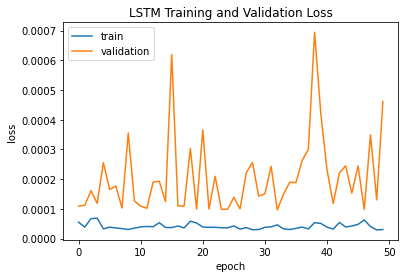

In [138]:
plt.plot(lstm_losses.history['loss'], label='train')
plt.plot(lstm_losses.history['val_loss'], label='validation')
plt.title('LSTM Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

GRU

In [139]:
model_gru = Sequential([
    GRU(50, activation='tanh', input_shape=(1, length)),
    Dense(1, activation='linear')
])

model_gru.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError()])

gru_losses = model_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
55/55 [==============================] - 0s 3ms/step - loss: 3.6009e-05 - mean_squared_error: 3.6009e-05 - val_loss: 1.0435e-04 - val_mean_squared_error: 1.0435e-04
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 3.8297e-05 - mean_squared_error: 3.8297e-05 - val_loss: 2.0546e-04 - val_mean_squared_error: 2.0546e-04
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 5.2891e-05 - mean_squared_error: 5.2891e-05 - val_loss: 1.8018e-04 - val_mean_squared_error: 1.8018e-04
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 3.3661e-05 - mean_squared_error: 3.3661e-05 - val_loss: 1.3141e-04 - val_mean_squared_error: 1.3141e-04
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 2.8771e-05 - mean_squared_error: 2.8771e-05 - val_loss: 1.8668e-04 - val_mean_squared_error: 1.8668e-04
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 3.4242e-05 - mean_squared_error: 3.4242e-05 - va

55/55 [==============================] - 0s 2ms/step - loss: 4.5188e-05 - mean_squared_error: 4.5188e-05 - val_loss: 1.6544e-04 - val_mean_squared_error: 1.6544e-04
Epoch 48/50
55/55 [==============================] - 0s 2ms/step - loss: 3.4002e-05 - mean_squared_error: 3.4002e-05 - val_loss: 1.0380e-04 - val_mean_squared_error: 1.0380e-04
Epoch 49/50
55/55 [==============================] - 0s 2ms/step - loss: 3.7054e-05 - mean_squared_error: 3.7054e-05 - val_loss: 2.0331e-04 - val_mean_squared_error: 2.0331e-04
Epoch 50/50
55/55 [==============================] - 0s 2ms/step - loss: 3.4190e-05 - mean_squared_error: 3.4190e-05 - val_loss: 2.9344e-04 - val_mean_squared_error: 2.9344e-04


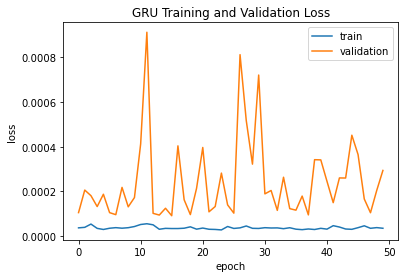

In [140]:
plt.plot(gru_losses.history['loss'], label='train')
plt.plot(gru_losses.history['val_loss'], label='validation')
plt.title('GRU Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

The LSTM model exhibits a more stable and faster convergence compared to the Simple RNN and GRU, which is represented by its smoother loss curves and lower final loss values. The Simple RNN shows overfitting, with greater differences in validation loss. These differences are likely due to LSTMs' and GRUs' ability to capture long-term patterns in data more efficiently than Simple RNNs. 

# Part 3

Yes, a traditional feed-forward network can be used to solve time series problems by converting time series data into a structured feature set, where each input feature represents a specific time step's data. This converts the problem to regression. However, feed-forward networks may not apture the sequential dependencies in time series data as effectively as RNNs, LSTMs, or GRUs, which are specifically designed to handle such sequences.

# Task 3

The cosine similarity measures the cosine of the angle between the word embeddings. This similarity ranges from -1 (very different meanings) to 1 (very similar meanings), and 0 indicates no similarity.

$\text{cosine similarity}$ = $\frac{A \cdot B}{\|A\| \|B\|}$


For the dissimilarity score, the Euclidean distance normalized by the dimensionality of the embeddings can be used. The score can range from 0, which means the words are identical. A larger value means the words are less similar.

$\text{dissimilarity score}$ = $\frac{\sqrt{\sum_{i=1}^{n} (A_i - B_i)^2}}{n}$


In [148]:
import gensim.downloader as api
model = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [154]:
import numpy as np
from gensim.models import KeyedVectors

def calculate_scores(w1, w2):

    if w1 in model.key_to_index and w2 in model.key_to_index:

        v1 = model[w1]
        v2 = model[w2]
        
        cosine = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        
        dissimilarity = np.sqrt(np.sum((v1 - v2) ** 2)) / len(v1)
        
        return cosine, dissimilarity
    
    else:
        return "Invalid", None

word1 = input("Enter the first word: ")
word2 = input("Enter the second word: ")

cosine, dissimilarity = calculate_scores(word1, word2)

if dissimilarity is not None:
    print(f"Cosine Similarity: {cosine}")
    print(f"Dissimilarity Score: {dissimilarity}")
    
else:
    print(cosine) 

Enter the first word: computer
Enter the second word: man
Cosine Similarity: 0.6237678527832031
Dissimilarity Score: 0.190484619140625
